In [3]:
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [4]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [6]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        #self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        #data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 46, 46))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [7]:
def make_train_test_datasets(images, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_labels, transform=transform),
            ImageDataset(test_images, test_labels, transform=transform))

In [8]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [9]:
model = ViTBase16(n_classes=2, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'model.pt'#'model.pt'#'other.pt' 
model = torch.load(name)

In [11]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/cutouts_Jack/'
hdu_list = fits.open(path_cutouts + 'real_lenses_Jack.fits')
lenses = hdu_list[1].data 
hdu_list.close()

# Negative cases
path_neg = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/negative_cases.fits'
hdu_list = fits.open(path_neg)
ind = random.sample(range(len(hdu_list[1].data)), len(lenses))
negatives = hdu_list[1].data[ind,:] 
hdu_list.close()

images = np.concatenate((lenses, negatives)).astype(np.float32)
labels_lenses, labels_negatives = np.zeros(len(lenses), dtype = np.int64), np.ones(len(lenses), dtype = np.int64)
labels = np.concatenate((labels_lenses, labels_negatives))

train_dataset, test_dataset = make_train_test_datasets(images, labels, test_size=0.99, transform=transform)
print(len(train_dataset), len(test_dataset))
print(sum(test_dataset.labels==0))
print(sum(test_dataset.labels==1))

4 494
247
247


In [12]:
search_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
prob_lim = 0.5

In [13]:
right_positives, wrong_positives = np.zeros((1, 3, 46, 46)), np.zeros((1, 3, 46, 46))
right_negatives, wrong_negatives = np.zeros((1, 3, 46, 46)), np.zeros((1, 3, 46, 46))
prob_list = []
for i_batch, sample in enumerate(tqdm(search_loader)):
    #if(i_batch==50): break
    
    sample_image, sample_label, sample_img = sample['image'], sample['label'] , sample['img']
        
    output = model(sample_image)
    predicted = output.argmax(dim=1).item()
    
    prob = nn.Softmax(dim=1)(output)
    prob = prob[:,0].detach().numpy()[0]
    prob_list.append(prob)
    
    predicted = 0 if prob >= prob_lim else 1
    
    if(predicted == 0 and sample_label.item() == 0):
        right_positives = np.append(right_positives, [np.array(sample_img[0])], axis = 0)
    elif(predicted == 1 and sample_label.item() == 0):
        wrong_positives = np.append(wrong_positives, [np.array(sample_img[0])], axis = 0)
    elif(predicted == 1 and sample_label.item() == 1):
        right_negatives = np.append(right_negatives, [np.array(sample_img[0])], axis = 0)
    elif(predicted == 0 and sample_label.item() == 1):
        wrong_negatives = np.append(wrong_negatives, [np.array(sample_img[0])], axis = 0)

right_positives = np.delete(right_positives, 0, axis = 0)
wrong_positives = np.delete(wrong_positives, 0, axis = 0)
right_negatives = np.delete(right_negatives, 0, axis = 0)
wrong_negatives = np.delete(wrong_negatives, 0, axis = 0)

  0%|          | 0/494 [00:00<?, ?it/s]

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [14]:
print(len(test_dataset))
print(len(prob_list))
print(len(right_positives), len(wrong_positives))
print(len(right_negatives), len(wrong_negatives))

494
494
131 116
236 11


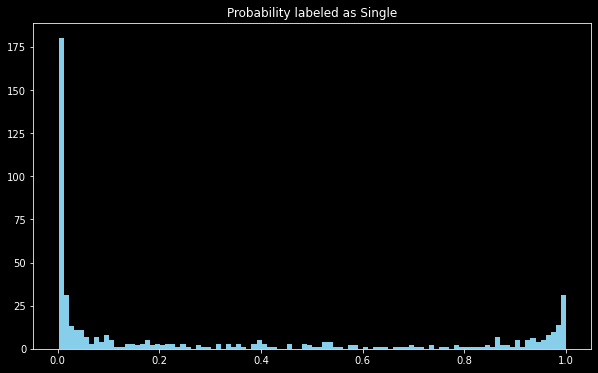

In [15]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [16]:
def make_plot_all(objects, true_labels, pred_labels):
    plt.figure(figsize=(15,10))
    for i in range(20):
        title = 'True: {}, Pred: {}'.format(true_labels[i], pred_labels[i])
        plt.subplot(4,5,i+1)
        plt.title(title)
        rgb = make_lupton_rgb(objects[i][2], objects[i][1], objects[i][0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.xticks([], [])
        plt.yticks([], [])
    plt.show()

Wrong lenses


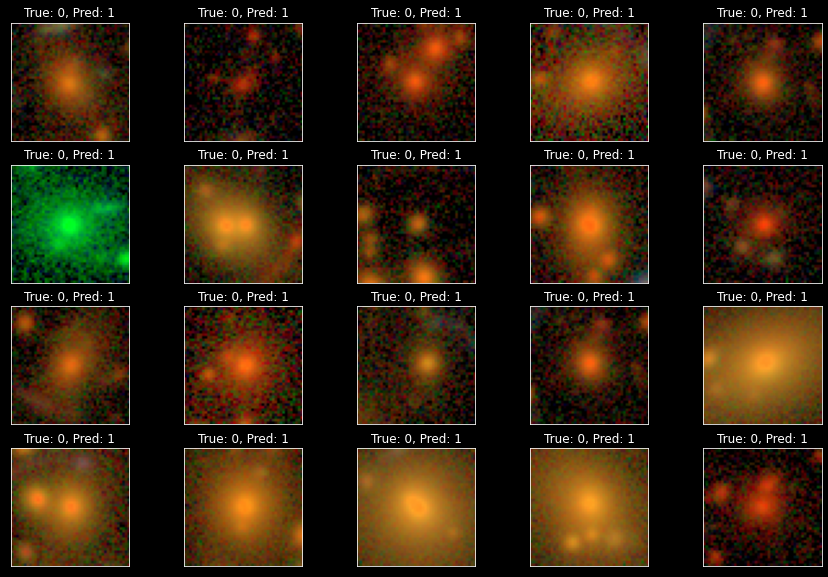

Wrong Negatives


IndexError: list index out of range

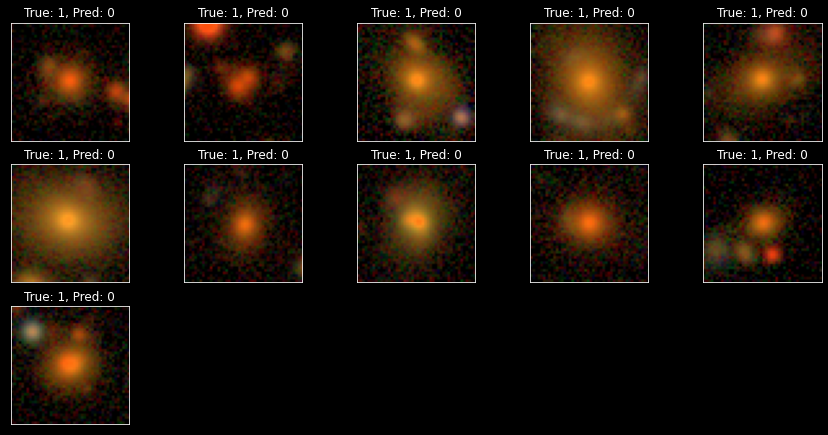

In [17]:
print('Wrong lenses')
idx = random.sample(range(len(wrong_positives)), 20)
true_labels_wrong = [0]*len(wrong_positives) # The true label
pred_labels_wrong = [1]*len(wrong_positives)
objects = wrong_positives[idx]
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)

print('Wrong Negatives')
idx = random.sample(range(len(wrong_negatives)), len(wrong_negatives))
true_labels_wrong = [1]*len(wrong_negatives) # The true label
pred_labels_wrong = [0]*len(wrong_negatives)
objects = wrong_negatives
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)

Right lenses


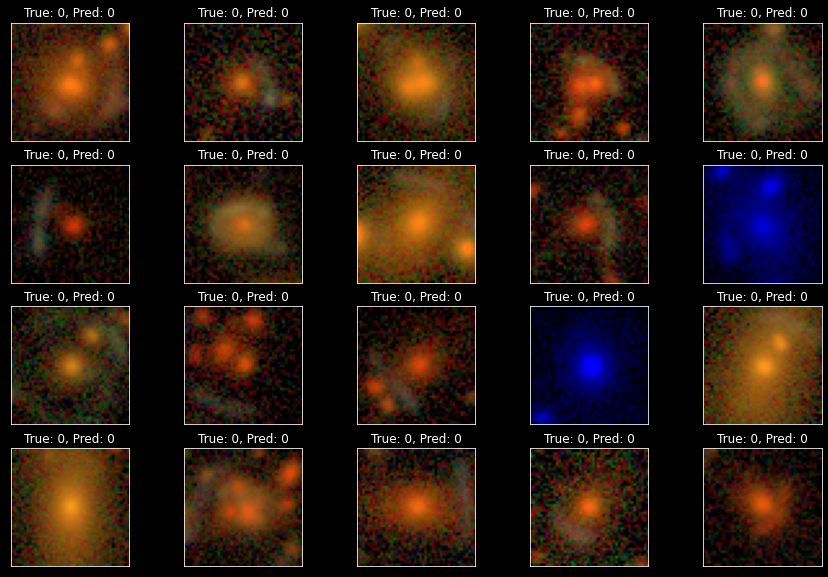

Right Negatives


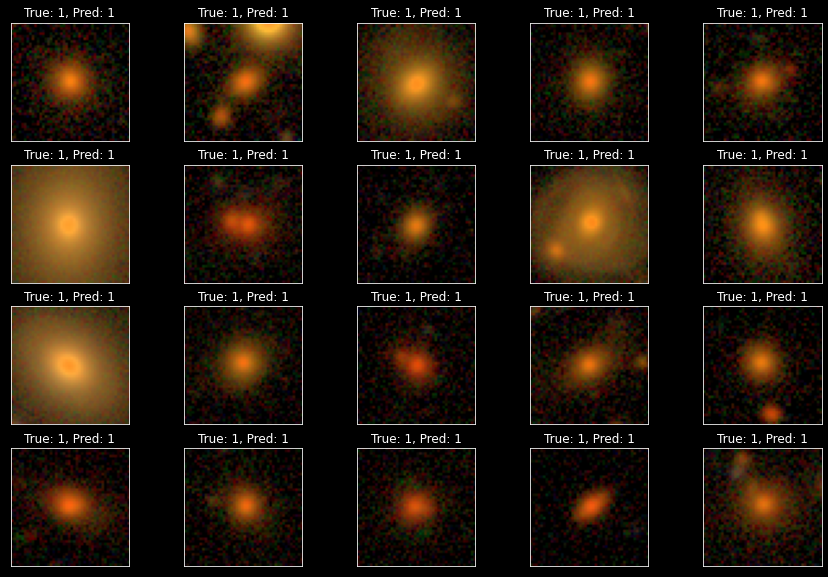

In [18]:
print('Right lenses')
idx = random.sample(range(len(right_positives)), 20)
true_labels_wrong = [0]*len(right_positives) # The true label
pred_labels_wrong = [0]*len(right_positives)
objects = right_positives[idx]
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)

print('Right Negatives')
idx = random.sample(range(len(right_negatives)), 20)
true_labels_wrong = [1]*len(right_negatives) # The true label
pred_labels_wrong = [1]*len(right_negatives)
objects = right_negatives[idx]
make_plot_all(objects, true_labels_wrong, pred_labels_wrong)